In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [11]:
train = pd.read_csv("../data/drugsComTrain_raw.tsv", delimiter='\t')
train = train.rename(columns = {"Unnamed: 0": "uniqueID"})
train['date'] = pd.to_datetime(train['date'])

In [12]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


In [13]:
## baseline classification model
from sklearn.dummy import DummyClassifier
X = train.iloc[:, 0:4]
y = train['rating']
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X,y)
dummy_clf.predict(X)
dummy_clf.score(X,y)

0.31611871268529484

In [14]:
## baseline regression model
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X,y)
y_pred = dummy_reg.predict(X)
print("Baseline MSE: ", mean_squared_error(y, y_pred))
print("Baseline r-squared: ", dummy_reg.score(X, y))

Baseline MSE:  10.70807206449809
Baseline r-squared:  0.0


In [115]:
from gensim.parsing.preprocessing import remove_stopwords
from nltk.corpus import stopwords
import nltk
from nltk.stem.snowball import SnowballStemmer
import requests, json, os, sys, time, re
from sklearn.model_selection import train_test_split, KFold
# import contractions

In [116]:
contractions = {
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


def clean_text(text):
    '''Text Preprocessing '''
    # Convert words to lower case
    text = text.lower()
    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\d+','', text)
    # remove stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
    # Stemming
#     lemm = nltk.stem.WordNetLemmatizer()
#     text = list(map(lambda word:list(map(lemm.lemmatize, word)), text))
    
    stemmer_snowball = SnowballStemmer('english')
    stem_words = []
    for w in text:
        x = stemmer_snowball.stem(w)
        stem_words.append(x)
    return stem_words

In [17]:
train['review'][98]

'"I&#039;m 30 years old.  I started having really bad skin about 2 years ago from maybe stress in my life.  But, I tried EVERYTHING to get rid of it and it just got worse.  I finally went to a dermatologist and she put me on spironolactone.  My skin started getting better in about two weeks. I LOVED it. I&#039;ve been taking it for about 6 months and I get compliments from Makeup artist and models (I&#039;m a hairstylist) about how good my skin is.  Another plus for me is my breasts went from a small B to a C! I decided to stop taking it for a week and my breasts went small again and my skin is getting a little oily. So I&#039;m going back on. I only take one a day."'

In [18]:
train['review_cleaned'] = train['review'].apply(lambda x: clean_text(x))

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, accuracy_score

In [20]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False)
tfidf_transform = TfidfTransformer(norm=None)

In [21]:
X = train[['review_cleaned','usefulCount']]
y = train['rating']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
X_bow = bow_transform.fit_transform(X_train['review_cleaned'])
X_tfidf = tfidf_transform.fit_transform(X_bow)

In [24]:
X_tfidf.shape

(120972, 29579)

In [25]:
## modeling
rmf_clf = RandomForestClassifier(max_features = 2000, class_weight="balanced")
rmf_clf.fit(X_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_features=2000)

In [26]:
X_bow_test = bow_transform.transform(X_test['review_cleaned'])
X_tfidf_test = tfidf_transform.transform(X_bow_test)

In [27]:
y_pred = rmf_clf.predict(X_tfidf_test)
accuracy_score(y_test, y_pred)

0.6580781153130812

In [36]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [38]:
cm = confusion_matrix(y_test, y_pred)

<AxesSubplot:>

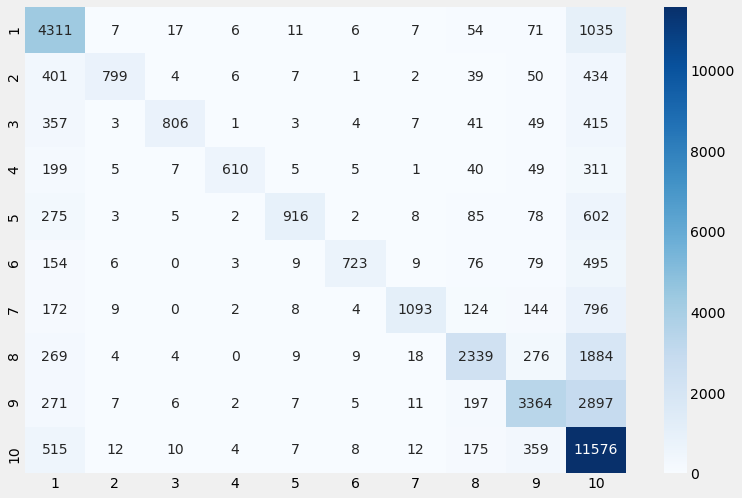

In [61]:
import seaborn as sn
df_cm = pd.DataFrame(cm, index=[i for i in range(1,11)],columns = [i for i in range(1,11)])
plt.figure(figsize=(12,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [92]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

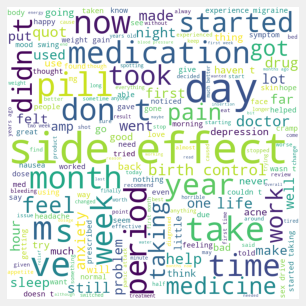

In [107]:
# frequent words
text1 = " ".join(review for review in train.review)
wordcloud1 = WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=10).generate(text1)
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

In [119]:
# test on unseen data
test = pd.read_csv("../data/drugsComTest_raw.tsv", delimiter='\t')
test = test.rename(columns = {"Unnamed: 0": "uniqueID"})
test['date'] = pd.to_datetime(test['date'])
test['review_cleaned'] = test['review'].apply(lambda x: clean_text(x))
X_bow_test1 = bow_transform.transform(test['review_cleaned'])
X_tfidf_test1 = tfidf_transform.transform(X_bow_test1)
y_pred1 = rmf_clf.predict(X_tfidf_test1)
y_true = test['rating']
cm = confusion_matrix(y_true, y_pred1)
print(accuracy_score(y_true, y_pred1))

0.654577242123275


<AxesSubplot:>

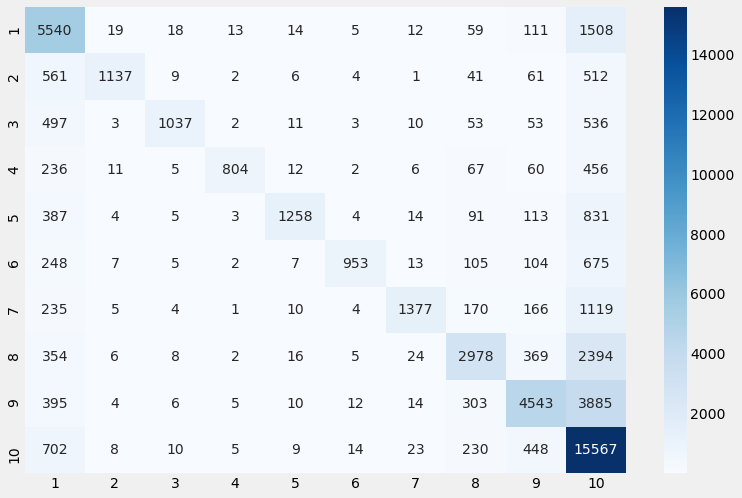

In [120]:
# unseen data confusion matrix
df_cm = pd.DataFrame(cm, index=[i for i in range(1,11)],columns = [i for i in range(1,11)])
plt.figure(figsize=(12,8))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')